# Model-building phase
- [Data Preprocessing](#Data-Preprocessing)
- [Supervised Models](#Supervised-Models)
    - [Random Forest](#**Random-Forest**)
    - [Gradient Boosting](#**Gradient-Boosting**)
    - [Perceptron](#Perceptron)
    - [SVM](#Support-Vector-Machines-(SVM))


In [1]:
import pandas as pd
import numpy as np
import random
from tools import *
from pprint import pprint
import pickle

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from  sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.decomposition import PCA

## Data Preprocessing 

In preprocessing the data we make use of the *prep* function, which simultaneously allows us both to deal with the missing values, giving us the choice of removing them, or partially removing them by replacing the remainder with the mean or median of the corresponding variable, and to scale the data, with the possibility of choosing the method by which to scale such data from all the scalers in scikit-learn, by default the MinMaxScaler is set. The function then takes as input a pandas DataFrame and outputs a numpy ndarray containing the cleaned data from the previous dataset.

Our idea is to generate two datasets: the first by eliminating all observations having at least one component with a missing value, the second by eliminating only 50 percent of those observations. Eventually we will train each model using both datasets and collect their metrics in order to assess whether on average such a reduction in missing values to be eliminated (thus replacing the missing part) resulted in any benefit.

### Scaling Data
To observe if there are difference in performance of the models  trained on a dataset with  all the Nan values imputed and in the models trained on a dataset with only a percentage of Nan values imputed, we have  created 2 dataset:
- one where we imputed all the Nan values (Water 100 dataset)
- one where we imputed only the half Nan values deleting the remain part of observations (Water 50 dataset)

In [3]:
random_seed = 42

In [4]:
# Setting random state for each model
water = pd.read_csv('dataset/drinking_water_potability.csv')
water50 = prep(
    data = water,
    target='Potability',
    axis='obs',
    perc=50,
    fill_method='mean',
    scaler= StandardScaler(),
    random_state = random_seed
)

print('original dataset size: ', water.shape, '- type: ', type(water))
print('cleaned dataset with 50% of missing values removed: ', np.shape(water50), '- type: ', type(water50))

original dataset size:  (3276, 10) - type:  <class 'pandas.core.frame.DataFrame'>
cleaned dataset with 50% of missing values removed:  (2644, 10) - type:  <class 'numpy.ndarray'>
cleaned dataset with no missing values removed:  (3276, 10) - type:  <class 'numpy.ndarray'>


### Splitting Data
At this point we proceed to divide the dataset into train set, validation set and test set. To do this, we make use of the *train_test_split()* function of scikit-learn.

In [7]:
#Water 50
X_train50, X_val50, X_test50, y_train50, y_val50, y_test50=split(df = water50,
                                                    target_index = 9,
                                                    validation = True,
                                                    perc_train = 0.7,
                                                    random_seed = random_seed,
                                                    verbose=True)

BEFORE SPLITTING: 

X shape:  (2644, 9)
y shape:  (2644,)

AFTER SPLITTING: 
X_train shape:  (1850, 9)
y_train shape:  (1850,)
X_test shape:  (794, 9)
y_test shape:  (794,)
X_val shape:  (397, 9)
y_val shape:  (397,)


## Supervised Models
The Supervised models that we chose are the following:
- **Random Forest**
- **XGBoost**
- **Support Vector Machine**
- **K-Nearest Neighbours**

In this part of the report we will train the above models reported  on Water100 dataset, that one with all the Nan values imputed.


### **Random Forest** <a name="random-forest"></a>

Random forest or random decision forest is an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees. 

Source: [link](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)



Confusion matrix: 


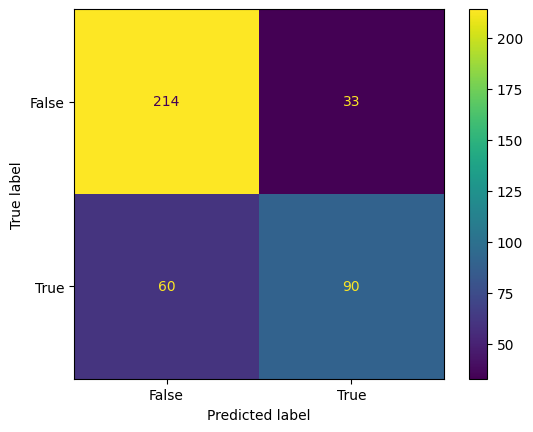

Model Performance: 

accuracy = 76.57%.
recall = 60.00%.
precision = 73.17%.
f1_score = 65.93%.


In [6]:
# Training base model
rf_base_w50 = RandomForestClassifier(random_state = random_seed)
rf_base_w50.fit(X_train50, y_train50)

#Computing the base model accuracy
rf_base_metrics_w50 = evaluate(rf_base_w50, X_val50, y_val50,conf_matrix=True)

#### Random Search w/ Cross Validation
 First of all we will start searching the best configuration of hyperparameters with a random search choosing among 
 thousand combinations of hyperparameters 100 random combinations, after this first step we will focus more with a grid 
search around the best combinations found with the random search

In [7]:
#Defining Random Forest Claasifier
rf = RandomForestClassifier(random_state = random_seed)
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
rf.get_params()

Parameters currently in use:



{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


As we can see there are many hyperparameter that we can tune, but for the moment we will focus more only on  the most importants

In [8]:
random_grid = {
    # Number of trees in random forest
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    # Number of features to consider at every split
    'max_features': ['auto', 'sqrt','log2', None],
    # Maximum number of levels in tree
    'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
    # Minimum number of samples required to split a node
    'min_samples_split': [2, 5, 10],
    # Minimum number of samples required at each leaf node
    'min_samples_leaf': [1, 2, 4],
    # Method of selecting samples for training each tree
    'bootstrap': [True, False],
    # Metrics  to measure the quality of a split.
    'criterion':['gini', 'entropy', 'log_loss']
}

pprint(random_grid)

rf_random_search_w50 = RandomizedSearchCV(
    estimator = rf, 
    param_distributions = random_grid,
    n_iter = 100, 
    cv = 3, 
    random_state=random_seed, 
    n_jobs = -1
    )

#rf_random_search.fit(X_train50, y_train50)

{'bootstrap': [True, False],
 'criterion': ['gini', 'entropy', 'log_loss'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt', 'log2', None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


Actually if we used all the possible combinations we should train the random forest 25920 times without considering the cross validation for each combinations, that would require a computational time too high, for this reason initially we will use the random search using only 100 random combinations among those available

##### Store and Load Models
To avoid  traininig each time the models we will save after every training of the models the results inside *Models folder* using pickle library


In [9]:
#pickle.dump(rf_random_search, open('Models50/Random_Forest_rs_w50.pkl', 'wb'))
rf_random_search_w50=pickle.load(open('Models50/Random_Forest_rs_w50.pkl', 'rb'))
rf_random_search_w50.best_params_

##### Comparing base model with tuned model with Random Search
To check if we are going in right direction we will compare the base model without tuning of parameters with the tuned model comparing the accuracy of both models on validation set

In [11]:
# Training tuned model
rf_random_w50 =  RandomForestClassifier(
    bootstrap = True,
    criterion='gini',
    max_depth=10,
    max_features='log2',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=2000,
    random_state=random_seed)

rf_random_w50.fit(X_train50,y_train50)

RandomForestClassifier(max_depth=10, max_features='log2', n_estimators=2000,
                       random_state=42)

Confusion matrix: 


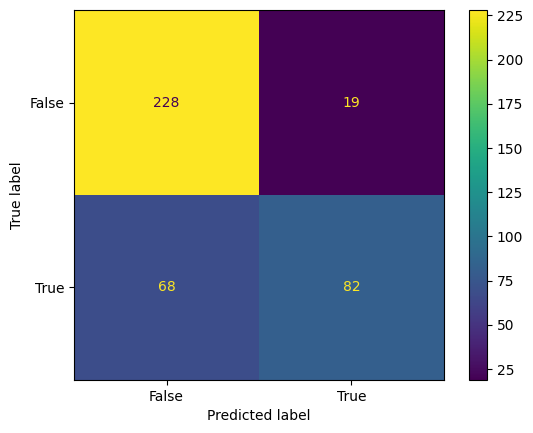

Model Performance: 

accuracy = 78.09%.
recall = 54.67%.
precision = 81.19%.
f1_score = 65.34%.
The tuned model had an improvement of 1.97%. respect the base model


In [12]:
#Computing the tuned model accuracy                                 
rf_random_metrics_w50 = evaluate(rf_random_w50, X_val50, y_val50,conf_matrix=True)

print('The tuned model had an improvement of {:0.2f}%. respect the base model'
        .format( 100 * (rf_random_metrics_w50[0] - rf_base_metrics_w50[0]) / rf_base_metrics_w50[0]))


#### Grid Search w/ Cross Validation
Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with GridSearchCV, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define. To use Grid Search, we make another grid based on the best values provided by random search:

In [13]:
#Defining Random Forest Claasifier
rf = RandomForestClassifier(random_state = random_seed)
rf_random_search_w50.best_params_

{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 10,
 'criterion': 'gini',
 'bootstrap': True}

In [14]:

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'criterion':['gini'],
    'max_depth': [8,10,12],
    'max_features': ['log2'],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [1,2,3],
    'n_estimators': [1800,1900,2000]
}
# Instantiate the grid search model
rf_grid_search_w50 = GridSearchCV(
    estimator = rf, 
    param_grid = param_grid, 
    cv = 5, n_jobs = -1, 
    verbose = 1)
                         
#rf_grid_search_w50.fit(X_train50, y_train50)

##### Save and load the model

In [15]:
#pickle.dump(rf_grid_search_w50.best_params_, open('Models50/Random_Forest_gs_w50.pkl', 'wb'))
rf_params_best_grid_w50 = pickle.load(open('Models50/Random_Forest_gs_w50.pkl', 'rb'))
rf_params_best_grid_w50

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 1800}

##### Comparing base model with tuned model with Grid Search
To check if we are going in right direction we will compare the base model without tuning of parameters with the tuned model comparing the accuracy of both models on validation set

In [16]:
# Training tuned model
rf_final_w50 =  RandomForestClassifier(
    bootstrap = True,
    criterion='gini',
    max_depth=10,
    max_features='log2',
    min_samples_leaf=1,
    min_samples_split=3,
    n_estimators=1800,
    random_state=random_seed)

rf_final_w50.fit(X_train50,y_train50)

RandomForestClassifier(max_depth=10, max_features='log2', min_samples_split=3,
                       n_estimators=1800, random_state=42)

Confusion matrix: 


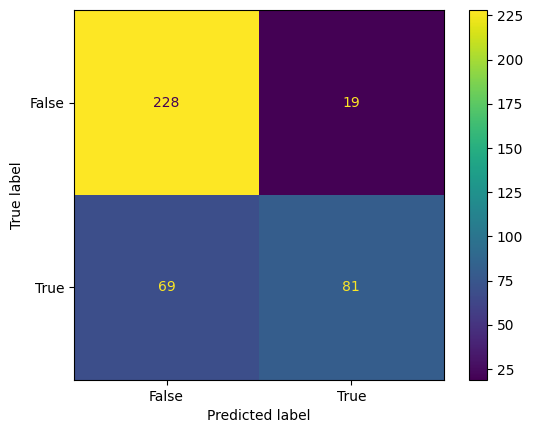

Model Performance: 

accuracy = 77.83%.
recall = 54.00%.
precision = 81.00%.
f1_score = 64.80%.
The tuned model with grid search had an improvement of 1.64%. respect the base model
The tuned model with grid search had an improvement of -0.32%. respect the tuned  model with random search


In [17]:
#Computing the tuned model accuracy                                 
rf_grid_metrics_w50 = evaluate(rf_final_w50, X_val50, y_val50,conf_matrix=True)

print('The tuned model with grid search had an improvement of {:0.2f}%. respect the base model'
                        .format( 100 * (rf_grid_metrics_w50[0] - rf_base_metrics_w50[0]) / rf_base_metrics_w50[0]))

print('The tuned model with grid search had an improvement of {:0.2f}%. respect the tuned  model with random search'
                        .format( 100 * (rf_grid_metrics_w50[0] - rf_random_metrics_w50[0]) / rf_random_metrics_w50[0]))

### **Gradient Boosting** <a name="gradient-boosting"></a>

In boosting, the individual models are not built on completely random subsets of data and features but sequentially by putting more weight on instances with wrong predictions and high errors. The general idea behind this is that instances, which are hard to predict correctly (“difficult” cases) will be focused on during learning, so that the model learns from past mistakes. When we train each ensemble on a subset of the training set, we also call this Stochastic Gradient Boosting, which can help improve generalizability of our model.The gradient is used to minimize a loss function, similar to how Neural Nets utilize gradient descent to optimize (“learn”) weights. 

Source: [link](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

Confusion matrix: 


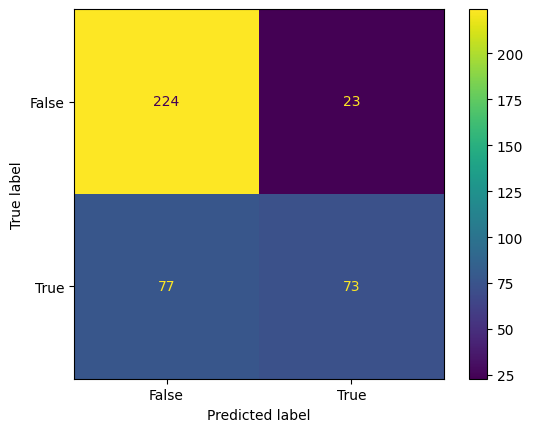

Model Performance: 

accuracy = 74.81%.
recall = 48.67%.
precision = 76.04%.
f1_score = 59.35%.


In [18]:
# Training base model
gb_base_w50 = GradientBoostingClassifier( random_state = random_seed)
gb_base_w50.fit(X_train50, y_train50)
#Computing the base model accuracy
gb_base_metrics_w50= evaluate(gb_base_w50, X_val50, y_val50,conf_matrix=True)

#### Random Search w/ Cross Validation

In [19]:
#Defining Random Forest Claasifier
gb = GradientBoostingClassifier(random_state = random_seed)
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(gb.get_params())

Parameters currently in use:

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [20]:
# Create the random grid
params_grid = {# The loss function to be optimized.
               'loss': ['log_loss','exponential'],
               # Learning rate shrinks the contribution of each tree by learning_rate
               'learning_rate':[0.001,0.01,0.1],
               # Number of trees in random forest
               'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]+[None],
               # Number of features to consider at every split
               'max_features': ['auto', 'sqrt','log2',None],
               # Maximum number of levels in tree
               'max_depth':  [int(x) for x in np.linspace(10, 110, num = 11)]+[None],
               # Minimum number of samples required to split a node
               'min_samples_split': [2, 5, 10],
               # Minimum number of samples required at each leaf node
               'min_samples_leaf': [1, 2, 4],
               # Metrics  to measure the quality of a split.
               'criterion':['friedman_mse','squared_error']}
pprint(params_grid)

# Random search of parameters, using 3 fold cross validation, search across 100 different combinations, and use all available cores
gb_random_search_w50 = RandomizedSearchCV(
    estimator = gb, 
    param_distributions = params_grid,
    n_iter = 100, cv = 3, 
    verbose=3, 
    random_state=random_seed, 
    n_jobs = -1)

#gb_random_search_w50.fit(X_train50, y_train50)

{'criterion': ['friedman_mse', 'squared_error'],
 'learning_rate': [0.001, 0.01, 0.1],
 'loss': ['log_loss', 'exponential'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt', 'log2', None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, None]}


Actually if we used all the possible combinations we should train the Gradient Boosting 103000 times without considering the cross validation for each combinations, that would require a computational time too high, for this reason initially we will use the random search using only 100 random combinations among those available

##### Store and load Models
To avoid  traininig each time the models we will save after every training of the models the results inside *Models folder* using pickle library

In [21]:
#Saving
#pickle.dump(gb_random_search_w50.best_params_, open('Models50/Gradient_Boosting_rs_w50.pkl', 'wb'))
#Loading
gb_params_best_random_w50=pickle.load(open('Models50/Gradient_Boosting_rs_w50.pkl', 'rb'))
gb_params_best_random_w50

{'n_estimators': 1200,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10,
 'loss': 'exponential',
 'learning_rate': 0.1,
 'criterion': 'friedman_mse'}

#### Comparing base model with tuned model with Random Search
To check if we are going in right direction we will compare the base model without tuning of parameters with the tuned model, comparing the accuracy of both models on validation set

In [22]:
# Training tuned model
gb_random_w50 =  GradientBoostingClassifier(
    loss='exponential',
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=1200,
    learning_rate=0.1,
    criterion='friedman_mse',
    random_state=random_seed)

gb_random_w50.fit(X_train50,y_train50)

GradientBoostingClassifier(loss='exponential', max_depth=10,
                           max_features='sqrt', min_samples_leaf=2,
                           n_estimators=1200, random_state=42)

Confusion matrix: 


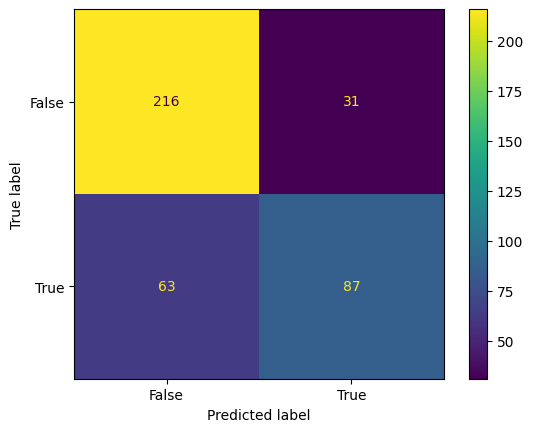

Model Performance: 

accuracy = 76.32%.
recall = 58.00%.
precision = 73.73%.
f1_score = 64.93%.
The tuned model with random search had an improvement of 2.02%. respect the base model


In [23]:
#Computing the tuned model accuracy                                 
gb_random_metrics_w50= evaluate(gb_random_w50, X_val50, y_val50,conf_matrix=True)

print('The tuned model with random search had an improvement of {:0.2f}%. respect the base model'
                        .format( 100 * (gb_random_metrics_w50[0] - gb_base_metrics_w50[0]) / gb_base_metrics_w50[0]))

#### Grid Search w/ Cross Validation
Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with GridSearchCV, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define. To use Grid Search, we make another grid based on the best values provided by random search:

In [24]:
gb_params_best_random_w50

{'n_estimators': 1200,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10,
 'loss': 'exponential',
 'learning_rate': 0.1,
 'criterion': 'friedman_mse'}

In [25]:
# Create the parameter grid based on the results of random search 
params_grid = {
    'loss': ['exponential'],
    'learning_rate': [0.1],
    'criterion':['friedman_mse'],
    'max_depth': [5,10,15],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [1,2,3],
    'n_estimators': [1100,1200,1300]
}
# Instantiate the grid search model
gb_grid_search_w50 = GridSearchCV(
    estimator = gb, 
    param_grid = params_grid, 
    cv = 5, 
    n_jobs = -1, 
    verbose = 3)

#gb_grid_search_w50.fit(X_train50, y_train50)

##### Store and load Models

In [26]:
#Saving
#pickle.dump(gb_grid_search_w50.best_params_, open('Models50/Gradient_Boosting_gs_w50.pkl', 'wb'))
#Loading
gb_params_best_grid_w50=pickle.load(open('Models50/Gradient_Boosting_gs_w50.pkl', 'rb'))
gb_params_best_grid_w50

{'criterion': 'friedman_mse',
 'learning_rate': 0.1,
 'loss': 'exponential',
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 1100}

#### Comparing tuned models 
To check if we are going in right direction we will compare the base model without tuning of parameters with the tuned model comparing the accuracy of both models on validation set

In [27]:
# Training tuned model
gb_final_w50 =  GradientBoostingClassifier(
    loss='exponential',
    max_depth=15,
    max_features='sqrt',
    min_samples_leaf=3,
    min_samples_split=2,
    n_estimators=1100,
    learning_rate=0.1,
    criterion='friedman_mse',
    random_state=random_seed)

gb_final_w50.fit(X_train50,y_train50)

GradientBoostingClassifier(loss='exponential', max_depth=15,
                           max_features='sqrt', min_samples_leaf=3,
                           n_estimators=1100, random_state=42)

Confusion matrix: 


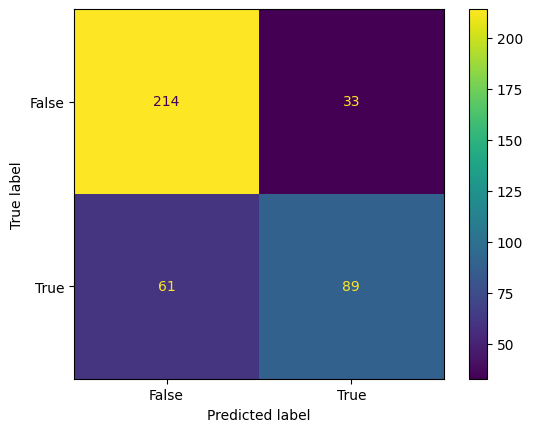

Model Performance: 

accuracy = 76.32%.
recall = 59.33%.
precision = 72.95%.
f1_score = 65.44%.
The tuned model with grid search had an improvement of 2.02%. respect the base model
The tuned model with grid search had an improvement of 0.00%. respect the tuned  model with random search


In [28]:
#Computing the tuned model accuracy                                 
gb_grid_metrics_w50 = evaluate(gb_final_w50, X_val50, y_val50,conf_matrix=True)

print('The tuned model with grid search had an improvement of {:0.2f}%. respect the base model'
                        .format( 100 * (gb_grid_metrics_w50[0] - gb_base_metrics_w50[0]) / gb_base_metrics_w50[0]))

print('The tuned model with grid search had an improvement of {:0.2f}%. respect the tuned  model with random search'
                        .format( 100 * (gb_grid_metrics_w50[0] - gb_random_metrics_w50[0]) / gb_random_metrics_w50[0]))


### **Support Vector Machines (SVM)**

A Support Vector Machine (SVM) is a very powerful and versatile Machine Learning model, capable of performing linear or nonlinear classification, regression, and even outlier detection. SVMs are particularly well suited for classification of complex but small- or medium-sized datasets.

In [9]:
svc_base = SVC(
    random_state= random_seed
)

print('Parameters currently in use:\n')
pprint(svc_base.get_params())

Parameters currently in use:

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


Confusion matrix: 


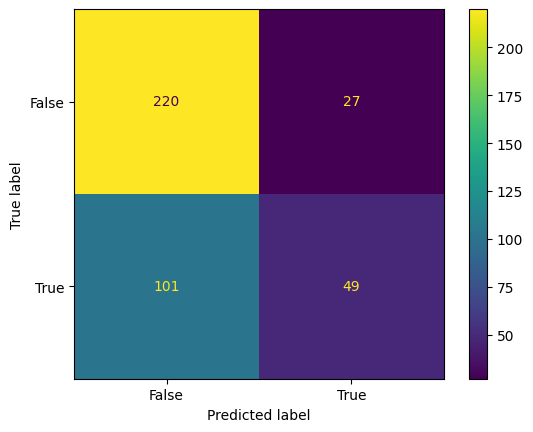

Model Performance: 

accuracy = 67.76%.
recall = 32.67%.
precision = 64.47%.
f1_score = 43.36%.


(0.6775818639798489,
 0.32666666666666666,
 0.6447368421052632,
 0.4336283185840708)

In [10]:
svc_base.fit(X = X_train50, y = y_train50)
evaluate(svc_base, X_val50, y_val50, conf_matrix=True)

#### Grid Search w/ Cross Validation

In [12]:
params_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01, 'scale', 'auto'],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree' : [2,3]
    }

svc_gs_w50 = GridSearchCV(
    estimator = SVC(random_state=random_seed),
    param_grid = params_grid,
    cv = 3, 
    verbose = 3,
    n_jobs = -1
)

svc_gs_w50.fit(X_train50, y_train50)

Fitting 3 folds for each of 120 candidates, totalling 360 fits
[CV 1/3] END C=0.1, degree=2, gamma=1, kernel=linear;, score=0.605 total time=   0.1s
[CV 3/3] END C=0.1, degree=2, gamma=1, kernel=linear;, score=0.604 total time=   0.1s
[CV 3/3] END C=0.1, degree=2, gamma=1, kernel=rbf;, score=0.604 total time=   0.1s
[CV 1/3] END C=0.1, degree=2, gamma=1, kernel=poly;, score=0.684 total time=   0.1s
[CV 2/3] END C=0.1, degree=2, gamma=1, kernel=linear;, score=0.605 total time=   0.1s
[CV 1/3] END C=0.1, degree=2, gamma=1, kernel=sigmoid;, score=0.502 total time=   0.1s
[CV 2/3] END C=0.1, degree=2, gamma=1, kernel=sigmoid;, score=0.519 total time=   0.1s
[CV 2/3] END C=0.1, degree=2, gamma=1, kernel=poly;, score=0.653 total time=   0.2s
[CV 1/3] END C=0.1, degree=2, gamma=0.1, kernel=linear;, score=0.605 total time=   0.1s
[CV 2/3] END C=0.1, degree=2, gamma=0.1, kernel=linear;, score=0.605 total time=   0.1s
[CV 3/3] END C=0.1, degree=2, gamma=0.1, kernel=linear;, score=0.604 total tim

GridSearchCV(cv=3, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'degree': [2, 3],
                         'gamma': [1, 0.1, 0.01, 'scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             verbose=3)

In [13]:
svc_gs_w50.best_params_

{'C': 1, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}

Confusion matrix: 


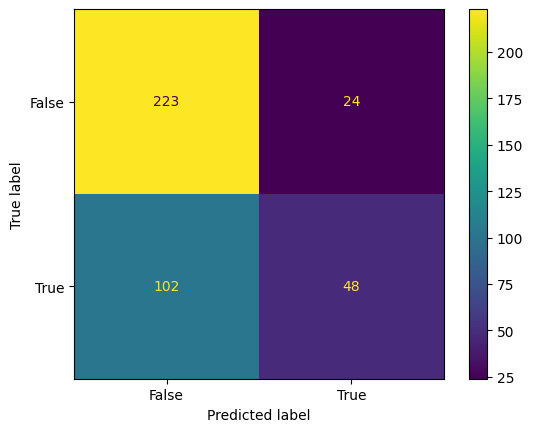

Model Performance: 

accuracy = 68.26%.
recall = 32.00%.
precision = 66.67%.
f1_score = 43.24%.


(0.6826196473551638, 0.32, 0.6666666666666666, 0.43243243243243246)

In [18]:
svc_final = SVC(
 C = 1,
 degree= 2,
 gamma= 0.1,
 kernel= 'rbf'
)
svc_final.fit(X_train50, y_train50)
evaluate(svc_final, X_val50, y_val50, conf_matrix=True)

##### Save and load the model

In [15]:
#pickle.dump(svc_gs_w50, open('Models50/svc_gs_w50.pkl', 'wb'))
#svc_gs_w50 = pickle.load(open('Models50/svc_gs_w50.pkl', 'rb'))

### **K-Nearest Neighbors (KNN)**

The k-nearest neighbors algorithm, also known as KNN or k-NN, is a non-parametric, supervised learning classifier, which uses proximity to make classifications or predictions about the grouping of an individual data point. While it can be used for either regression or classification problems, it is typically used as a classification algorithm, working off the assumption that similar points can be found near one another.

In [19]:
knn_base = KNeighborsClassifier()

print('Parameters currently in use:\n')
pprint(knn_base.get_params())

Parameters currently in use:

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}


Confusion matrix: 


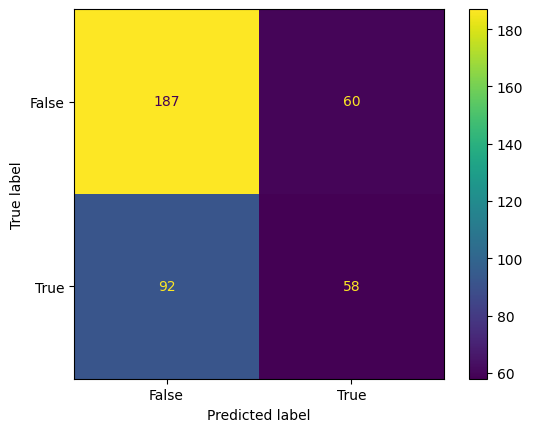

Model Performance: 

accuracy = 61.71%.
recall = 38.67%.
precision = 49.15%.
f1_score = 43.28%.


(0.6171284634760705,
 0.38666666666666666,
 0.4915254237288136,
 0.43283582089552236)

In [20]:
knn_base.fit(X_train50, y_train50)
evaluate(knn_base, X_val50, y_val50, conf_matrix=True)

#### Grid Search w/ Cross Validation

In [21]:
params_grid = {
    'n_neighbors': [x for x in range(3,30)],
    'weights' : ['uniform', 'distance'],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p' : [2,3,4],
    'leaf_size' : [int(x) for x in np.linspace(start= 5, stop= 50, num = 10)]
    }

knn_gs_w50 = GridSearchCV(
    estimator = KNeighborsClassifier(),
    param_grid = params_grid,
    cv = 3, 
    verbose = 3,
    n_jobs = -1
)

knn_gs_w50.fit(X_train50, y_train50)

Fitting 3 folds for each of 6480 candidates, totalling 19440 fits
[CV 1/3] END algorithm=auto, leaf_size=5, n_neighbors=3, p=2, weights=uniform;, score=0.606 total time=   0.1s
[CV 3/3] END algorithm=auto, leaf_size=5, n_neighbors=3, p=2, weights=uniform;, score=0.593 total time=   0.1s
[CV 3/3] END algorithm=auto, leaf_size=5, n_neighbors=3, p=2, weights=distance;, score=0.594 total time=   0.0s
[CV 1/3] END algorithm=auto, leaf_size=5, n_neighbors=3, p=2, weights=distance;, score=0.608 total time=   0.0s
[CV 2/3] END algorithm=auto, leaf_size=5, n_neighbors=3, p=2, weights=distance;, score=0.629 total time=   0.0s
[CV 3/3] END algorithm=auto, leaf_size=5, n_neighbors=3, p=3, weights=uniform;, score=0.601 total time=   0.1s
[CV 1/3] END algorithm=auto, leaf_size=5, n_neighbors=3, p=3, weights=distance;, score=0.609 total time=   0.1s
[CV 2/3] END algorithm=auto, leaf_size=5, n_neighbors=3, p=3, weights=distance;, score=0.640 total time=   0.1s
[CV 1/3] END algorithm=auto, leaf_size=5,

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                         'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                         24, 25, 26, 27, 28, 29],
                         'p': [2, 3, 4], 'weights': ['uniform', 'distance']},
             verbose=3)

In [22]:
knn_gs_w50.best_params_

{'algorithm': 'auto',
 'leaf_size': 5,
 'n_neighbors': 29,
 'p': 2,
 'weights': 'distance'}

Confusion matrix: 


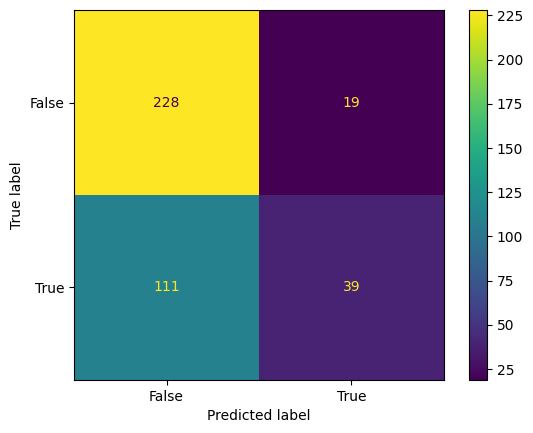

Model Performance: 

accuracy = 67.25%.
recall = 26.00%.
precision = 67.24%.
f1_score = 37.50%.


(0.672544080604534, 0.26, 0.6724137931034483, 0.375)

In [24]:
knn_final = KNeighborsClassifier(
    algorithm='auto',
    leaf_size=5,
    n_neighbors=29,
    p=2,
    weights='distance'
)
knn_final.fit(X_train50, y_train50)
evaluate(knn_final, X_val50, y_val50, conf_matrix=True)

##### Save and load the model

In [1]:
#pickle.dump(knn_gs_w50, open('Models50/knn_gs_w50.pkl', 'wb'))
#knn_gs_w50 = pickle.load(open('Models50/knn_gs_w50.pkl', 'rb'))

## **Unsupervised models**

Unsupervised learning, also known as unsupervised machine learning, uses machine learning algorithms to analyze and cluster unlabeled datasets. These algorithms discover hidden patterns or data groupings without the need for human intervention. Its ability to discover similarities and differences in information make it the ideal solution for exploratory data analysis, cross-selling strategies, customer segmentation, and image recognition.There are two main unsupervised learning problems: 

- **Clustering**

Unsupervised learning is mainly used in clustering analysis.

Clustering analysis is a grouping effort in which the members of a group (i.e., a cluster) are more similar to each other than the members of the other clusters.
There are many different clustering methods available. They usually utilize a type of similarity measure based on selected metrics such as Euclidean or probabilistic distance. Bioinformatic sequence analysis, genetic clustering, pattern mining, and object recognition are some of the clustering problems that may be tackled with the unsupervised learning approach.

- **Dimensionality Reduction**

Another use case of unsupervised learning is dimensionality reduction. Dimensionality is equivalent to the number of features used in a dataset. In some datasets, you may find hundreds of potential features stored in individual columns. In most of these datasets, several of these columns are highly correlated. Therefore, we should either select the best ones, i.e., feature selection, or extract new features combining the existing ones, i.e., feature extraction. This is where unsupervised learning comes into play. Dimensionality reduction methods help us create neater and cleaner models that are free of noise and unnecessary features.


In [ ]:
df_w50 = pd.DataFrame(water50, columns = water.columns)
y_w50=df_w50['Potability']
df_w50=df_w50.drop(columns='Potability')
df_w50.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,0.000559,0.260496,-0.135371,0.111608,0.918918,1.730636,-1.175663,1.300083,-1.299112
1,-2.212632,-2.047015,-0.382625,-0.308468,0.026220,2.089204,0.270464,-0.650714,0.681614
2,0.666458,0.852017,-0.236248,1.359694,0.026220,-0.097573,0.779182,-0.008695,-1.179564
3,0.809420,0.550448,0.005013,0.591165,0.613124,-0.791950,1.251527,2.149493,0.846659
4,1.318795,-0.466880,-0.457109,-0.364468,-0.616076,-0.350976,-0.820627,-2.198727,0.133356


### Dimensionality Reduction models
The Dimensionality Reduction models that we chose are the following:
- **PCA**
- **?**

#### **Principal Component Analysis**
Principal component analysis (PCA) is a popular technique for analyzing large datasets containing a high number of dimensions/features per observation, increasing the interpretability of data while preserving the maximum amount of information, and enabling the visualization of multidimensional data. 

PCA is particularly useful when the available variables are highly correlated.Correlation indicates that there is redundancy1 in the data. Due to this redundancy,
PCA can be used to reduce the original variables into a smaller number of new variables (i.e. the PCs) explaining most of the variance in the original variables.

Source: [link](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA)

In [ ]:
# Applying PCA function 
pca = PCA(n_components = 9)
df_w50_pca = pca.fit_transform(df_w50)

explained_variance_w50 = pca.explained_variance_ratio_

In [ ]:
pca_df_w50 = pd.DataFrame(data = df_w50_pca,
                           columns = ['PC1', 'PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9']
                          )

Let'see how much variability explain the first 2 PCs

In [ ]:
print('Explained variation per principal component: {}'.format(explained_variance))

Explained variation per principal component: [0.13338887 0.12630124 0.11734674 0.11371574 0.11044354 0.10744107
 0.1056698  0.09849932 0.08719369]


In [ ]:
sum(explained_variance_w50[0:2])

0.26241354972220143

To explain to 80% of variability we need 7 PCs over 9, this means that the variables are enough independent each others

In [ ]:
sum(explained_variance_w50[0:7])

0.8145574516790438

<Figure size 640x480 with 0 Axes>

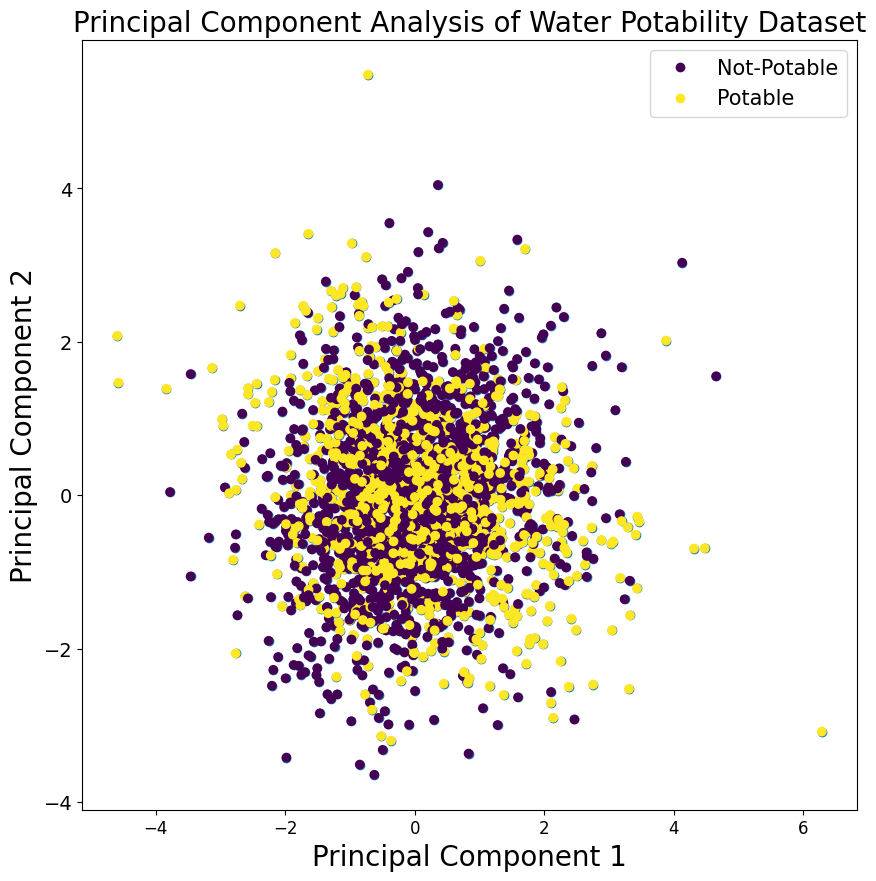

In [ ]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component 1',fontsize=20)
plt.ylabel('Principal Component 2',fontsize=20)
plt.scatter(x=pca_df_w50['PC1'],y=pca_df_w50['PC2'])
plt.title("Principal Component Analysis of Water Potability Dataset",fontsize=20)


plot=plt.scatter(x=pca_df_w50[ 'PC1'],
            y=pca_df_w50[ 'PC2'], 
            c = y_w50)

plt.legend(plot.legend_elements()[0], ['Not-Potable','Potable'],prop={'size': 15})
plt.show()

### Clustering models
The Clustering models that we chose are the following:
- **K-Means**
- **DBSCAN**


#### **K-Means**
K-means is one of the most widely used and best performing clustering algorithms. Despite this, it is a very simple algorithm to implement and use.

K-means is based on so-called centroids. The centroid is a point belonging to the feature space that averages the distances between all the data belonging to the cluster associated with it. It thus represents a kind of barycenter of the cluster and in general, precisely because of its characteristics, is not one of the points in the dataset.

Source: [link](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

Text(0, 0.5, 'Sum Squared Distance')

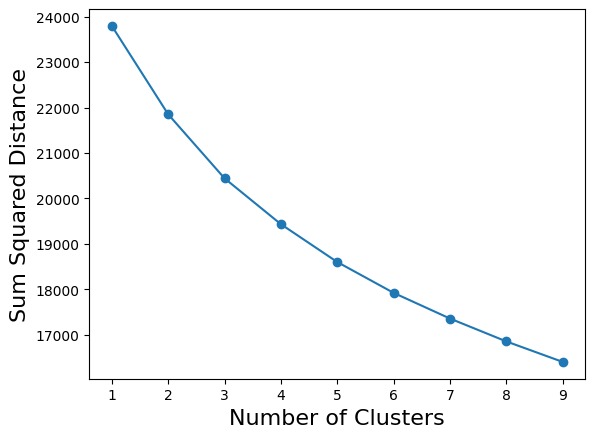

In [ ]:
#To check the optimal possible number of clusters we will use elbow method
sdq = {}
for k in range(1, 10):
                # n_init is the number of times the k-means algorithm is run with different centroid seeds
    km = KMeans(n_init="auto",
                # Init random assign the centroids randomly
                init="random", 
                # n_clusters define the number of clusters to research at each iteration
                n_clusters=k
                )

    km.fit(df_w50)
    # Inertia contains Sum of squared distances of samples to their closest cluster center,
    #  weighted by the sample weights if provided.
    sdq[k] = km.inertia_

# Plotting the results
plt.plot(list(sdq.keys()), list(sdq.values()), marker="o")
plt.xlabel("Number of Clusters", fontsize=16)
plt.ylabel("Sum Squared Distance", fontsize=16)

#### **DBSCAN**
Density-based spatial clustering of applications with noise (DBSCAN) is a data clustering algorithm proposed by Martin Ester, Hans-Peter Kriegel, Jörg Sander and Xiaowei Xu in 1996.It is a density-based clustering non-parametric algorithm: given a set of points in some space, it groups together points that are closely packed together (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions (whose nearest neighbors are too far away). DBSCAN is one of the most common clustering algorithms and also most cited in scientific literature.

Source: [link](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

In [ ]:
db = DBSCAN(eps=0.3, min_samples=10).fit(df_w50)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 0
Estimated number of noise points: 2644
